# **NGSA Final Project**
## Prediction of the worldwide propagation of an H1N1 virus from a single starting point

### Caroline FAVART, Rym LAABIYAD, Juan LONDONO, Alizée POIRIER-RENARD, Vivien ROBERT

In [1]:
import pandas as pd
import networkx as nx
from math import exp
import matplotlib.pyplot as plt
import numpy as np
from itertools import count

In [2]:
from jupyterthemes import jtplot
%matplotlib inline
jtplot.reset()

C:\Users\juann\Anaconda3\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\juann\Anaconda3\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\juann\Anaconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


# 1. Importing Data and Creating the Graph

In [3]:
nodes = pd.read_csv('routes.csv', header=None, names=['i', 'j'])
g = nx.from_pandas_edgelist(nodes, 'i', 'j',create_using=nx.DiGraph())
print('Number of nodes', g.number_of_nodes())
print('Number of edges', g.number_of_edges())

Number of nodes 151
Number of edges 3622


In [4]:
# We have a dataframe of countries (nodes)
countries = pd.read_csv('data.csv')
countries.set_index('country', inplace=True)
countries['population'] = 1000000*countries['population']
# Travellers are for an entire year, but our timeline is weekly
countries['travellers'] = countries['travellers']/52

countries.head()

,population,travellers,hdi
country,,,
Afghanistan,32760000.0,37113.596154,0.498
Albania,2900000.0,79730.769231,0.773
Algeria,39100000.0,54596.153846,0.747
Angola,26920000.0,23932.519231,0.581
Antigua and Barbuda,98000.0,19996.326923,0.780


In [5]:
# For each country, we need the travellers going from the neighboring countries
def return_list_neighbors(i, g):
    return [in_neighb for (in_neighb,j) in g.in_edges(i)]
print('Albania\'s neighbors :', return_list_neighbors('Albania', g))

# For all countries
def compute_sum_travelers_neighboring_countries(g):
    sum_travel_neighbors = []
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum_n = 0
        for n in neighbors:
            sum_n += countries.loc[n]['travellers']
        sum_travel_neighbors.append(sum_n)
    return sum_travel_neighbors
countries['sum_travel_neighbors'] = compute_sum_travelers_neighboring_countries(g)

countries.head()

Albania's neighbors : ['Austria', 'Germany', 'Greece', 'Italy', 'Slovenia', 'Turkey', 'United Kingdom']


,population,travellers,hdi,sum_travel_neighbors
country,,,,
Afghanistan,32760000.0,37113.596154,0.498,2.738878e+06
Albania,2900000.0,79730.769231,0.773,3.826346e+06
Algeria,39100000.0,54596.153846,0.747,1.192336e+07
Angola,26920000.0,23932.519231,0.581,9.607654e+06
Antigua and Barbuda,98000.0,19996.326923,0.780,4.422177e+06


In [6]:
# W_ij the weight between country i and j represents the number of travellers between i and j
def compute_edge_weight(i, j):
    return countries.loc[i]['travellers']*countries.loc[j]['travellers']/(countries.loc[i]['sum_travel_neighbors'])
        
def add_edge_weights():
    for e in g.edges():
        g[e[0]][e[1]]['weight'] = compute_edge_weight(e[0], e[1])

add_edge_weights()
print('France - Singapore :', g['France']['Singapore'])
print('Singapore - France :', g['Singapore']['France'])

France - Singapore : {'weight': 9515.122402410567}
Singapore - France : {'weight': 12656.470084309465}


# 2. Building Our Model

In [7]:
# Initialisation for our model :
r0 = 5
alpha = 0.15
beta = 0.4
period = 52
mortality_rate = 0.15
country_start = 'France'
nb_infected_start = 1

In [8]:
# Creation of new data frames
pop_tot = pd.DataFrame(index = countries.index)
incubating = pd.DataFrame(index = countries.index)
sick = pd.DataFrame(index = countries.index)
infected = pd.DataFrame(index = countries.index)
recovered = pd.DataFrame(index = countries.index)
susceptible = pd.DataFrame(index = countries.index)
deceased = pd.DataFrame(index = countries.index)
ri = pd.DataFrame(index = countries.index)

# # Initialisation for t=0 :
pop_tot['t=0'] = countries['population']
incubating['t=0'] = np.zeros(countries.shape[0])
sick['t=0'] = np.zeros(countries.shape[0])
infected['t=0'] = np.zeros(countries.shape[0])
recovered['t=0'] = np.zeros(countries.shape[0])
susceptible['t=0'] = countries['population']
deceased['t=0'] = np.zeros(countries.shape[0])
ri['t=0'] = np.zeros(countries.shape[0])


# We infect the starting country with a certain number of people
infected.loc[country_start]['t=0'] = nb_infected_start
incubating.loc[country_start]['t=0'] = nb_infected_start
susceptible.loc[country_start]['t=0'] = pop_tot.loc[country_start]['t=0'] - incubating.loc[country_start]['t=0']

### Computing the reproduction number $R_i$ (average number of people that an incubated person will infect in a week) 
It should :

- Be inversely proportionate to the HDI (with an impact corresponding to beta). We used a linearly decreasing function such that : for a maximal HDI, it should be equal to minus beta times $r_0$, for a minimal HDI, it should be equal to plus beta times $r_0$. Solving these two conditions, we obtain the following affine function's parameters $\large a=-2*\beta*\frac{r_0}{max-min}$ and $\large b=\beta*r_0 - a*min$ where max and min respectively represent the maximum and minimum of the HDI. 
Thus, the HDI's function is $\large f(HDI)=r_0 +a*HDI + b$.

- Decrease with time, since awareness increases, the illness mutates and the immune system adjusts. We used the shape of the sigmoid function to build a function with values between 1 and 0, decreasing slowly at the beginning and at the end, with a higher slope around the middle of the period, here 26 weeks, depending on the alpha parameter. We obtain $\large time(t)=1-\frac{1}{1+e^{(-\alpha * (t-26))}}$. See plot below. 

Finally, we have $R_i(t)=f(HDI)*time(t)$.

In [9]:
print('min HDI: ',countries.hdi.min())
print('max HDI: ',countries.hdi.max())
print('max HDI: ',countries.hdi.median())


min HDI:  0.354
max HDI:  0.946
max HDI:  0.747


In [10]:
# Contamination decreases with time

def time(t):
    # translation to the right
    x=t-30
    # oposite sigmoid + 1
    f=1 -(1/(1+exp(-alpha*x)))
    return f

# Plotting our time function
exp_test=[time(t) for t in range(52)]
plt.title("Time function (sigmoid like)")
plt.xlabel("Time in weeks")
plt.plot(exp_test)

# We calculate the average number infected by an incubated person in a week
# The higher the HDI of a country, the less people will be infected
def reproduction_number_by_country(t):
    minim=countries.hdi.min()
    maxim=countries.hdi.max()
    # Affine function of HDI :
    a=-2*beta*r0/(maxim-minim)
    b=beta*r0-a*minim
    if t==0:
        return (r0 +a*countries['hdi'] + b)
    else:
        # We calculate the percentage of people that can still be infected
        to_be_infected = susceptible.iloc[:,t] / pop_tot.iloc[:,t]
        result = ri.iloc[:,t-1] * to_be_infected
        return result*time(t)

# Let us initialize the ri for t=0
ri['t=0'] = reproduction_number_by_country(0)

print('Country \t HDI \t RI')
print('Afghanistan : \t', countries.loc['Afghanistan']['hdi'], '\t',ri.loc['Afghanistan', 't=0'])
print('France : \t', countries.loc['France']['hdi'], '\t',ri.loc['France', 't=0'])

Country 	 HDI 	 RI
Afghanistan : 	 0.498 	 6.027027027027026
France : 	 0.894 	 3.35135135135135


### Plotting the distibution for the different $R_i$ at $t=0$

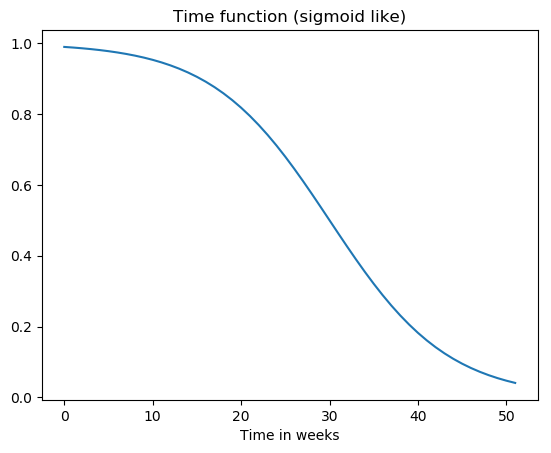

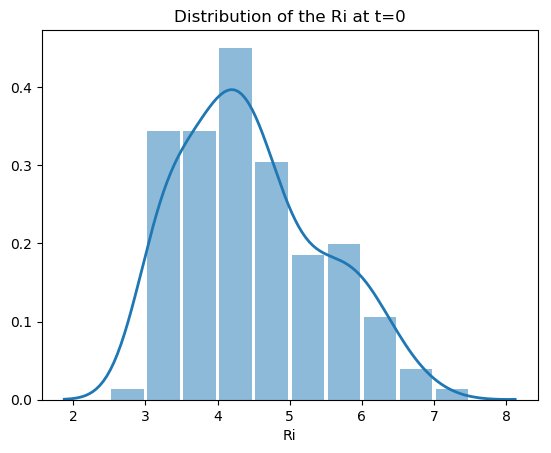

In [11]:
import seaborn as sns

plt.figure()
sns.distplot(ri['t=0'], kde_kws={"lw": 2}, bins = np.arange(2,8,0.5), hist_kws={"linewidth": 3, "rwidth": 0.9, "alpha": 0.5})
plt.title('Distribution of the Ri at t=0')
plt.xlabel('Ri')
plt.show()

In [12]:
# Incubated people coming to the country at time t
def number_incubated_coming(t):
    incubated_coming = pd.DataFrame(index = countries.index)
    incubated_coming['nb_coming']=np.zeros(countries.shape[0])
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum = 0
        for j in neighbors:
            sum += g[j][i]['weight']*incubating.loc[j]['t='+str(t-1)]/(pop_tot.loc[j]['t='+str(t-1)] - sick.loc[j]['t='+str(t-1)])
        incubated_coming.loc[i,'nb_coming'] = round(sum)
        
    return incubated_coming

In [13]:
# Function to actualize (add column corresponding to t) each dataframe t>0 :

def infection_actualization(t, country_start) :
    if t>0 :
        index='t='+str(t)
        # actualizing deceased, recovered, pop_tot and susceptible => variables of "beginning of period":
        deceased[index]=mortality_rate*sick.iloc[:,t-1]
        recovered[index]=sick.iloc[:,t-1]-deceased[index]
        pop_tot[index]=pop_tot.iloc[:,t-1]-deceased[index]
        susceptible[index]=susceptible.iloc[:,t-1]-incubating.iloc[:,t-1]

        # actualizing ri :
        ri[index] = reproduction_number_by_country(t)

        # actualizing incubating, sick & infected => variables depending on the newly infected people:

        # sick people at time t are the incubated of t-1 who stayed in the country
        sick[index]=incubating.iloc[:,t-1]*(1-(countries.travellers/(pop_tot.iloc[:,t-1]-sick.iloc[:,t-1])))
        
        incubating[index]=sick[index]*ri.iloc[:,t-1]+number_incubated_coming(t).iloc[:,0]*(ri.iloc[:,t-1])

        infected[index]=sick[index]+number_incubated_coming(t).iloc[:,0]+incubating[index]

In [14]:
# Initialisation for our model :
r0 = 5
alpha = 0.15
beta = 0.4
period = 30
mortality_rate = 0.15
country_start = 'France'
nb_infected_start = 1

In [15]:
# Creation of new data frames
pop_tot = pd.DataFrame(index = countries.index)
incubating = pd.DataFrame(index = countries.index)
sick = pd.DataFrame(index = countries.index)
infected = pd.DataFrame(index = countries.index)
recovered = pd.DataFrame(index = countries.index)
susceptible = pd.DataFrame(index = countries.index)
deceased = pd.DataFrame(index = countries.index)

# # Initialisation for t=0 :
pop_tot['t=0'] = countries['population']
incubating['t=0'] = np.zeros(countries.shape[0])
sick['t=0'] = np.zeros(countries.shape[0])
infected['t=0'] = np.zeros(countries.shape[0])
recovered['t=0'] = np.zeros(countries.shape[0])
susceptible['t=0'] = countries['population']
deceased['t=0'] = np.zeros(countries.shape[0])


# We infect the starting country with a certain number of people
infected.loc[country_start]['t=0'] = nb_infected_start
incubating.loc[country_start]['t=0'] = nb_infected_start
susceptible.loc[country_start]['t=0'] = pop_tot.loc[country_start]['t=0'] - incubating.loc[country_start]['t=0']

In [16]:
# Create the values for the dataframes, for all periods

def data_creation(period, country_start):
    for i in range(1,period+1):
        infection_actualization(i,country_start = country_start)
        print("Number of periods processed:", i)

In [17]:
data_creation(period, country_start)

Number of periods processed: 1
Number of periods processed: 2
Number of periods processed: 3
Number of periods processed: 4
Number of periods processed: 5
Number of periods processed: 6
Number of periods processed: 7
Number of periods processed: 8
Number of periods processed: 9
Number of periods processed: 10
Number of periods processed: 11
Number of periods processed: 12
Number of periods processed: 13
Number of periods processed: 14
Number of periods processed: 15
Number of periods processed: 16
Number of periods processed: 17
Number of periods processed: 18
Number of periods processed: 19
Number of periods processed: 20
Number of periods processed: 21
Number of periods processed: 22
Number of periods processed: 23
Number of periods processed: 24
Number of periods processed: 25
Number of periods processed: 26
Number of periods processed: 27
Number of periods processed: 28
Number of periods processed: 29
Number of periods processed: 30


## Creation of the DataFrame that will indicate the status of each country, through time
* **Epidemic threshold**: We set it at 200 for 100,000 inhabitants.

The cycle that a country can go trhough is the following:
Susceptible => Exposed => Epidemic => Recovered

* *Susceptible:* all countries start as susceptible.
* *Exposed*: if one person is infected in the country, it is considered exposed.
* *Epidemic:* if the number of infected surpasses the epidemic threshold.
* *Recovered*: if the country was infected, but goes back under the epidemic threshold.

In [18]:
# Creation of the DataFrame and the threshold :
zeros = np.zeros(shape=infected.shape)
country_status=pd.DataFrame(zeros, index = infected.index, columns = infected.columns)
epidemic_threshold=200/100000

# Initialization at t=0, all countries are susceptible except the exposed country
country_status.replace(to_replace= 0, value = 'Susceptible',inplace=True)
country_status.loc[country_start,'t=0']='Exposed'

# Replacing the Epidemic and the Exposed:
for index, row in infected.iterrows():
    for col in infected :
        if infected.loc[index, col] / pop_tot.loc[index, col] > epidemic_threshold:
            country_status.loc[index, col] = 'Epidemic'
        elif infected.loc[index, col] >= 1:
            country_status.loc[index, col] = 'Exposed'

# Replacing the Recovered:
for index, row in country_status.iterrows():
    i=0
    for col in country_status :
        if (country_status.loc[index, col] == 'Exposed' or country_status.loc[index, col] =='Susceptible') and i>0:
            if country_status.loc[index,'t='+str(i-1)] == 'Epidemic' or country_status.loc[index,'t='+str(i-1)] =='Recovered' :
                country_status.loc[index, col]='Recovered'
        i+=1

### Pandemic status :
As the criterion to define a pandemic is not precisely set and varies depending on the illness, we have decided to set the pandemic threshold at **10 countries** under epidemic.

In [19]:
# Creation of the Pandemic status DataFrame: 

# Initialization : the default status is False (no pandemic)
pandemic_status=pd.DataFrame(index=country_status.columns)
pandemic_status['status']=False

# There is a pandemic if more than 10 countries suffer from an epidemic : 
for t in pandemic_status.index : 
    if ('Epidemic' in country_status.loc[:,t].values) and (country_status.loc[:,t].value_counts()['Epidemic']>=10) :
        pandemic_status.loc[t,'status']=True

# Period of pandemic : 
print('Pandemic starts at: ', pandemic_status.status[pandemic_status.status==True].index[0])
print('Pandemic ends at: ', pandemic_status.status[pandemic_status.status==True].index[-1])

Pandemic starts at:  t=16
Pandemic ends at:  t=25


In [20]:
# Displaying the result
country_status.sample(n=5)

,t=0,t=1,t=2,t=3,t=4,t=5,t=6,t=7,t=8,t=9,...,t=21,t=22,t=23,t=24,t=25,t=26,t=27,t=28,t=29,t=30
country,,,,,,,,,,,,,,,,,,,,,
Algeria,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,...,Epidemic,Epidemic,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered
Mauritius,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,...,Epidemic,Epidemic,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered
United Arab Emirates,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Exposed,Exposed,Exposed,...,Epidemic,Epidemic,Epidemic,Epidemic,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered
Burkina Faso,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,...,Epidemic,Epidemic,Epidemic,Epidemic,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered
Japan,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Exposed,Exposed,...,Exposed,Exposed,Exposed,Exposed,Exposed,Exposed,Exposed,Exposed,Exposed,Susceptible


In [21]:
# Saving our results in dedicated DataFrames : 

pop_tot_model = pop_tot.copy()
incubating_model = incubating.copy()
sick_model = sick.copy()
infected_model = infected.copy()
recovered_model = recovered.copy()
susceptible_model = susceptible.copy()
deceased_model = deceased.copy()
ri_model = ri.copy()

# 3. Plotting Our Findings

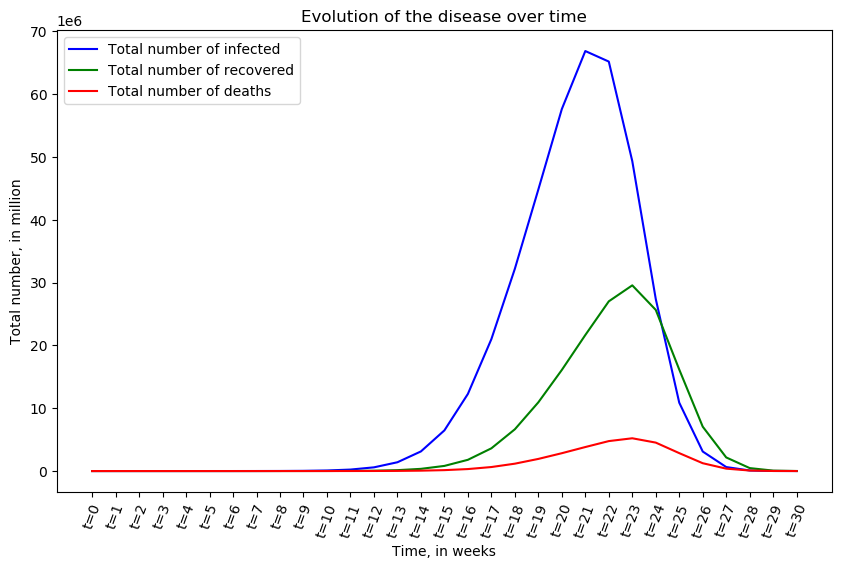

In [22]:
# Plotting the Evolution of the Disease over time : 

# The x-axis will be time : 
x_g = infected_model.columns

# We need to sum for each country the numbers of infected, recovered and deceased :
tot_inf=infected_model.sum()
tot_rec=recovered_model.sum()
tot_dead=deceased_model.sum()

fig, ax = plt.subplots(figsize=(10,6))

plt.plot(x_g, tot_inf, label = 'Total number of infected', color = 'b')
plt.plot(x_g, tot_rec, label = 'Total number of recovered', color = 'g')
plt.plot(x_g, tot_dead, label = 'Total number of deaths', color = 'r')


plt.title("Evolution of the disease over time")
plt.xlabel("Time, in weeks")
plt.xticks(rotation=70)
ax.ticklabel_format(axis='y',scilimits=(6,6))
plt.ylabel("Total number, in million")
plt.legend()

plt.show()

### Observations :
We observe that there is a peak of the number of infected around the 21st week. Then, this number decreases steeply (partially because of the time function). 
The number of recovered/deceased follows the shape of the infection curve, with a shift corresponding to the incubation and sickness delay.

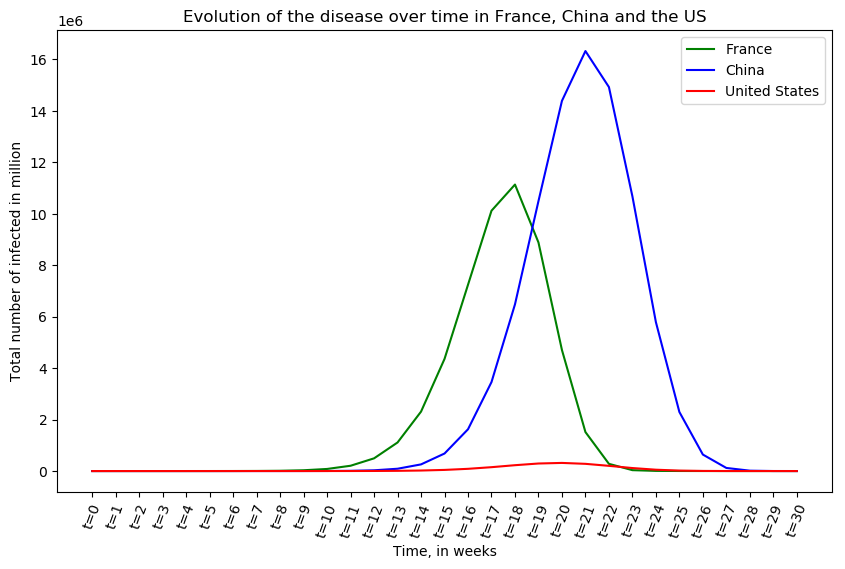

In [23]:
# Plotting the Evolution of the Disease in 3 different countries : the starting point (France), China and the US : 

fig, ax = plt.subplots(figsize=(10,6))

plt.plot(x_g, infected_model.loc['France'], label = 'France', color = 'g')
plt.plot(x_g, infected_model.loc['China'], label = 'China', color = 'b')
plt.plot(x_g, infected_model.loc['United States'], label = 'United States', color = 'r')


plt.title("Evolution of the disease over time in France, China and the US")
plt.xlabel("Time, in weeks")
plt.xticks(rotation=70)
plt.ylabel("Total number of infected in million")
ax.ticklabel_format(axis='y',scilimits=(6,6))
plt.legend()

plt.show()

### Observations :
France is the starting point of the infection. We observe that the sickness took almost 10 week to start to grow strongly. The peak is achieved at t=18 and then it decreases.
In a contaminated country such as China, the infection peak happens later, at t=22, but the shape of the curve is the same.
Furthermore, it is interesting to notice that a highly connected country such as the United States does not suffer from the epidemic.

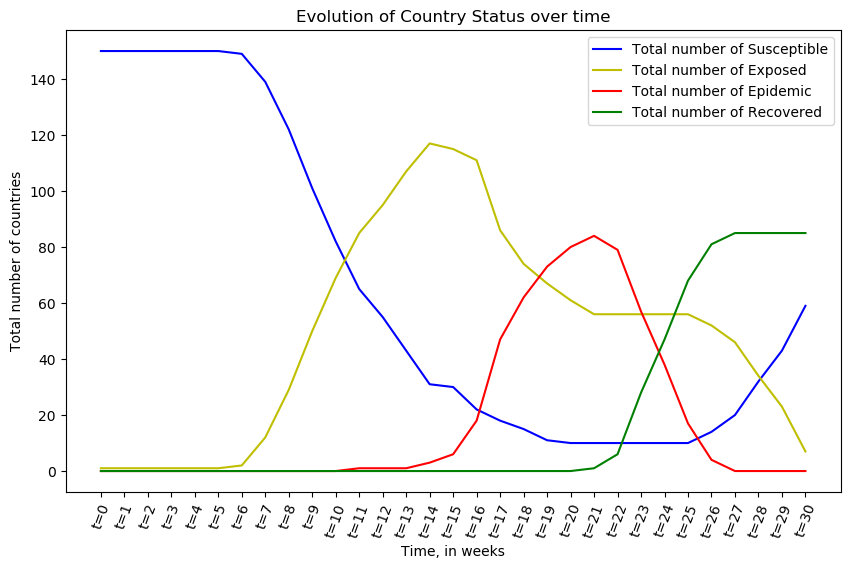

In [59]:
# Plotting the Evolution of Country statuses over time : 

# The x-axis will be time : 
x_g = infected_model.columns

# We need to count for each time the numbers of countries under the different statuses : Susceptible, Exposed, Epidemic and Recovered

# Creating a Data Frame that counts countries for each status at each time t
tot_df = pd.concat([pd.DataFrame(country_status.iloc[:,i].value_counts()) for i in range(country_status.shape[1])], axis = 1, sort=True)
tot_df.fillna(0, inplace = True)

tot_sus=list(tot_df.loc['Susceptible'])
tot_exp=list(tot_df.loc['Exposed'])
tot_epi=list(tot_df.loc['Epidemic'])
tot_rec=list(tot_df.loc['Recovered'])

fig, ax = plt.subplots(figsize=(10,6))

plt.plot(x_g, tot_sus, label = 'Total number of Susceptible', color = 'b')
plt.plot(x_g, tot_exp, label = 'Total number of Exposed', color = 'y')
plt.plot(x_g, tot_epi, label = 'Total number of Epidemic', color = 'r')
plt.plot(x_g, tot_rec, label = 'Total number of Recovered', color = 'g')

plt.title("Evolution of Country Status over time")
plt.xlabel("Time, in weeks")
plt.xticks(rotation=70)
plt.ylabel("Total number of countries")
plt.legend()

plt.show()

### Observations :
We may see that during 6 weeks, the total number of *Exposed* countries is very low. After this period, it steadily increases and reaches its peak at t=13.  

From this point, many countries become *Epidemic*. The pandemic status -more thant 10 *Epidemic* countries- is reached only 3 weeks after the first epidemics are declared. The peak is reached at 21 weeks, after which it quickly decreases as the number of *Recovered* countries increases.

# 4. Building the Graph

## Degree analysis: IN and OUT degrees together

In [60]:
# Degree (IN+OUT degrees) per country
in_out_degree = nx.degree(g)
list_in_out_degree = [country for country in in_out_degree]
list_country_name = [degree[0] for degree in list_in_out_degree]
list_degree = [degree[1] for degree in list_in_out_degree]

In [61]:
# Average, min and max (IN+OUT degrees)
degree_min = min(list_in_out_degree, key = lambda t: t[1])
print('Minimum degree is '+ str(degree_min[1]) + ' for '+str(degree_min[0]))
degree_max = max(list_in_out_degree, key = lambda t: t[1])
print('Maximum degree is '+ str(degree_max[1])+' for '+str(degree_max[0]))
degree_mean = np.mean(list_degree)
print('Mean degree is '+ str(degree_mean))
degree_median = np.median(list_degree)
print('Median degree is '+ str(degree_median))

Minimum degree is 2 for Marshall Islands
Maximum degree is 190 for France
Mean degree is 47.973509933774835
Median degree is 38.0


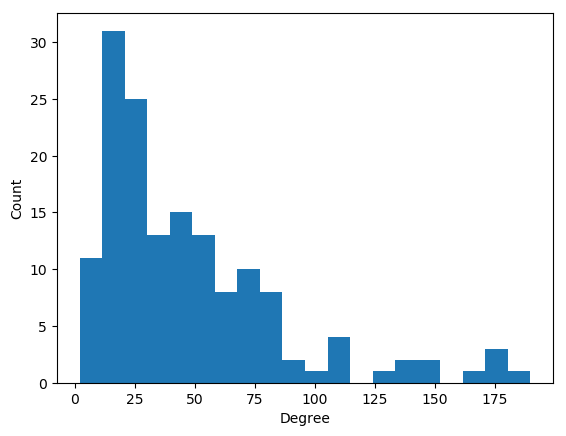

In [62]:
# Degree distribution (IN+OUT degrees)
plt.hist(list_degree,bins = 20)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

## Degree Analysis: IN degrees

In [63]:
# In degree per country
in_degree = g.in_degree()
list_country_in_degree = [country for country in in_degree]
list_in_degree = [degree[1] for degree in list_country_in_degree]

In [64]:
# Average, min and max IN degrees
in_degree_min = min(list_country_in_degree, key = lambda t: t[1])
print('Minimum IN degree is '+ str(in_degree_min[1]) + ' for '+str(in_degree_min[0]))
in_degree_max = max(list_country_in_degree, key = lambda t: t[1])
print('Maximum IN degree is '+ str(in_degree_max[1])+' for '+str(in_degree_max[0]))
in_degree_mean = np.mean(list_in_degree)
print('Mean IN degree is '+ str(in_degree_mean))
in_degree_median = np.median(list_in_degree)
print('Median IN degree is '+ str(in_degree_median))

Minimum IN degree is 1 for Marshall Islands
Maximum IN degree is 95 for France
Mean IN degree is 23.986754966887418
Median IN degree is 19.0


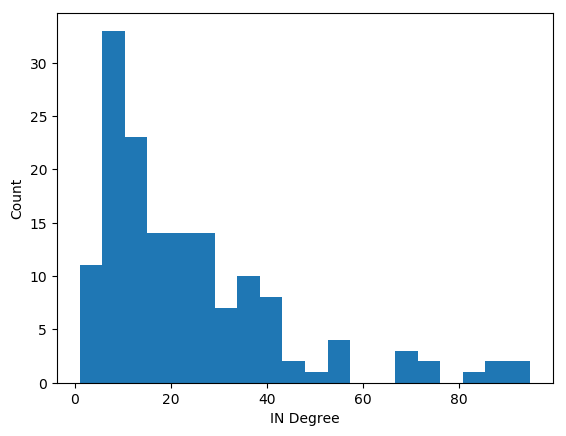

In [65]:
# IN Degree distribution
plt.hist(list_in_degree,bins = 20)
plt.xlabel('IN Degree')
plt.ylabel('Count')
plt.show()

In [66]:
# in_degree centrality 
in_degree_centrality = nx.in_degree_centrality(g)

## Degree Analysis: OUT degrees

In [67]:
# OUT degree per country
out_degree = g.out_degree()
list_country_out_degree = [country for country in out_degree]
list_out_degree = [degree[1] for degree in list_country_out_degree]

In [68]:
# Average, min and max out degrees
out_degree_min = min(list_country_out_degree, key = lambda t: t[1])
print('Minimum out degree is '+ str(out_degree_min[1]) + ' for '+str(out_degree_min[0]))
out_degree_max = max(list_country_out_degree, key = lambda t: t[1])
print('Maximum out degree is '+ str(out_degree_max[1])+' for '+str(out_degree_max[0]))
out_degree_mean = np.mean(list_out_degree)
print('Mean out degree is '+ str(out_degree_mean))
out_degree_median = np.median(list_out_degree)
print('Median out degree is '+ str(out_degree_median))

Minimum out degree is 1 for Marshall Islands
Maximum out degree is 95 for France
Mean out degree is 23.986754966887418
Median out degree is 19.0


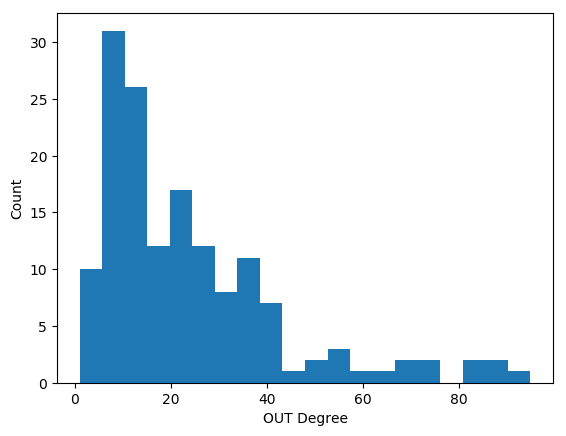

In [69]:
# OUT Degree distribution
plt.hist(list_out_degree,bins = 20)
plt.xlabel('OUT Degree')
plt.ylabel('Count')
plt.show()

In [70]:
# out_degree centrality 
out_degree_centrality = nx.out_degree_centrality(g)

## Shortest path to disease starting node/country

In [71]:
# compute the shortest path to the starting point of the disease
# All countries can be reached in less than 4 steps starting from France
starting_country = 'France'
shortest_path_starting_node = [len(nx.shortest_path(g, source=starting_country, target=target, weight=None)) for target in list_country_name ]
shortest_path_starting_node = pd.DataFrame(shortest_path_starting_node,index=countries.index,columns=['shortest_path'])
shortest_path_starting_node

,shortest_path
country,
Afghanistan,3
Albania,2
Algeria,2
Angola,2
Antigua and Barbuda,3
Argentina,3
Armenia,2
Australia,2
Austria,3


## Betweeness centrality 

In [72]:
# Betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass through v
betweeness_centrality = nx.betweenness_centrality(g)
betweeness_centrality = [betweeness_centrality[centrality] for centrality in betweeness_centrality]
betweeness_centrality = pd.DataFrame(betweeness_centrality,index=countries.index,columns=['betweeness_centrality'])
betweeness_centrality

,betweeness_centrality
country,
Afghanistan,0.000050
Albania,0.000902
Algeria,0.019344
Angola,0.002298
Antigua and Barbuda,0.002334
Argentina,0.000148
Armenia,0.065463
Australia,0.069665
Austria,0.000011


# 5. Node Deletion: modeling the international community's reaction to the pandemic

*Random node deletion*: We delete a random number of nodes -between 0% and 40%- at time t=i, the first period for which the pandemic is declared. It corresponds to a reaction of random countries when the pandemic is announced.

*Targeted node deletion* : We delete the same number of nodes as before, but this time we target the most connected nodes. It corresponds to the reaction of the most exposed countries, which should decide to close their air routes to other countries when the pandemic is announced. 

As we still want to count the number of infected in the "deleted nodes", we aim at erasing all the edges of the list of the selected nodes at time t=i, by setting its out weights to 0.  
To do so, we have to modify our previous fomulas.

In [73]:
# Modifying the incubated people coming to the country at time t
def number_incubated_coming_deletion(t,countries_to_delete):
    incubated_coming = pd.DataFrame(index = countries.index)
    incubated_coming['nb_coming']=np.zeros(countries.shape[0])
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum = 0
        for j in neighbors:
            # Modifying the formula so that the erased edges are not counted
            if j not in countries_to_delete:
                sum += g[j][i]['weight']*incubating.loc[j]['t='+str(t-1)]/(pop_tot.loc[j]['t='+str(t-1)] - sick.loc[j]['t='+str(t-1)])
        incubated_coming.loc[i,'nb_coming'] = round(sum)
        
    return incubated_coming

In [74]:
# Modifying the function that creates the DataFrames at time t

def infection_actualization_deletion(t, country_start, pandemic_start, countries_to_delete) :
    if t==0:
        print("Error: t must be strictly greater than zero ! --' ")
        
    # We have 2 cases: before and after the pandemic starts : 
    
    # Before the pandemic, nothing changes :
    elif t< pandemic_start:
        index='t='+str(t)
        # actualizing deceased, recovered, pop_tot and susceptible => variables of "beginning of period":
        deceased[index]=mortality_rate*sick.iloc[:,t-1]
        recovered[index]=sick.iloc[:,t-1]-deceased[index]
        pop_tot[index]=pop_tot.iloc[:,t-1]-deceased[index]
        susceptible[index]=susceptible.iloc[:,t-1]-incubating.iloc[:,t-1]

        # actualizing ri :
        ri[index] = reproduction_number_by_country(t)

        # actualizing incubating, sick & infected => variables depending on the newly infected people:
        # sick people at time t are the incubated of t-1 who stayed in the country
        sick[index]=incubating.iloc[:,t-1]*(1-(countries.travellers/(pop_tot.iloc[:,t-1]-sick.iloc[:,t-1])))
        incubating[index]=sick[index]*ri.iloc[:,t-1]+number_incubated_coming(t).iloc[:,0]*(ri.iloc[:,t-1])
        infected[index]=sick[index]+number_incubated_coming(t).iloc[:,0]+incubating[index]
    
    # We modify the function after the pandemic for sick, incubating and infected:
    else:
        index='t='+str(t)
        index_prev = 't='+str(t-1)
        # actualizing deceased, recovered, pop_tot and susceptible => variables of "beginning of period":
        deceased[index]=mortality_rate*sick.iloc[:,t-1]
        recovered[index]=sick.iloc[:,t-1]-deceased[index]
        pop_tot[index]=pop_tot.iloc[:,t-1]-deceased[index]
        susceptible[index]=susceptible.iloc[:,t-1]-incubating.iloc[:,t-1]

        # actualizing ri :
        ri[index] = reproduction_number_by_country(t)
        
        # We compute the number of incubated coming before the loops to gain computation time
        nb=number_incubated_coming_deletion(t, countries_to_delete)
        
        # we need to compute row by row, as it depends on the countries (deleted or not)
        for i,row in infected.iterrows():
            # Reminder : sick people are considered not contagious for simplicity
            
            # countries to delete don't have contact to other countries anymore, the sickness only continues spreading inside
            if i in countries_to_delete :
                sick.loc[i,index]=incubating.loc[i,index_prev]
                incubating.loc[i,index]=sick.loc[i,index]*ri.loc[i,index_prev]
                infected.loc[i,index]=sick.loc[i,index]+incubating.loc[i,index]
                
            # we use the new number_incubated_coming_deletion function to consider travellers only from remaining countries : :    
            else :
                sick.loc[i,index]=incubating.loc[i,index_prev]*(1-(countries.travellers[i]/(pop_tot.loc[i,index_prev]-sick.loc[i,index_prev])))
                incubating.loc[i,index]=sick.loc[i,index]*ri.loc[i,index_prev]+ nb.loc[i,'nb_coming']*(ri.loc[i,index_prev])
                infected.loc[i,index]=sick.loc[i,index]+ nb.loc[i,'nb_coming']+incubating.loc[i,index]

In [75]:
# Creating a formula to create all DataFrames

def data_creation_deletion(period, country_start, pandemic_start, countries_to_delete):
    for i in range(1,period+1):
        infection_actualization_deletion(i,country_start = country_start, pandemic_start = pandemic_start, countries_to_delete = countries_to_delete)
    if i == pandemic_start:
        print("\n", "START OF THE PANDEMIC !!!", "\n")
    print("Number of periods processed:", i)


We have to create functions to compute the lists of countries to delete following the two methods (random and targeted).

In [76]:
# Defining the countries to delete

# First case : random deletion :
import random 

# We take the indicated percentage of a random sample of the nodes
def countries_to_delete_random(percentage) :
    ListOfNodes = g.nodes()
    NumberofNodes = g.number_of_nodes()
    
    sample = int(NumberofNodes*(percentage/100))
    RandomSample = random.sample(ListOfNodes, sample)
    return RandomSample

# test 
print(countries_to_delete_random(25))

# Second case : Targeted deletion (highest degrees countries are targeted first) :
def countries_to_delete_targeted(percentage):
    NumberofNodes = g.number_of_nodes()
    sample = int(NumberofNodes*(percentage/100))
    
    # Finding nodes with highest degree
    tuples = sorted([(d,n) for n, d in g.degree()], reverse=True)
    
    nodes_to_delete = []
    for j in range(sample):
        nodes_to_delete.append(tuples[j][1])
    return nodes_to_delete

# test 
print(countries_to_delete_targeted(25))

['Austria', 'Senegal', 'Slovakia', 'Marshall Islands', 'Bahamas', 'Mexico', 'Kyrgyzstan', 'Chad', 'South Korea', 'Brunei', 'Jamaica', 'Singapore', 'Russia', 'United Arab Emirates', 'Angola', 'Iran', 'Bulgaria', 'Guatemala', 'Bhutan', 'Belarus', 'Tanzania', 'Yemen', 'Greece', 'India', 'Netherlands', 'Israel', 'Congo', 'United Kingdom', 'Lithuania', 'Thailand', 'Egypt', 'Venezuela', 'Czech Republic', 'Peru', 'Cyprus', 'Pakistan', 'Hong Kong']
['France', 'Germany', 'United Kingdom', 'Turkey', 'United Arab Emirates', 'Italy', 'Netherlands', 'United States', 'Spain', 'Russia', 'Switzerland', 'China', 'Austria', 'Belgium', 'Thailand', 'Canada', 'India', 'Egypt', 'Denmark', 'Greece', 'Saudi Arabia', 'Sweden', 'Israel', 'Poland', 'Ethiopia', 'Morocco', 'Finland', 'Czech Republic', 'South Africa', 'South Korea', 'Portugal', 'Norway', 'Hong Kong', 'Kenya', 'Ukraine', 'Singapore', 'Jordan']


### Implementation of the node deletion :
First, we need to reinitialize our parameters. Then, in a loop, we will compute the number of incubated for each percentage deleted by first erasing our DataFrames and then, running the data_creation_deletion function. 
We run this once for random deletion and once for targeted deletion.

In [77]:
# Random deletion 

# Initialisation of the parameters for our model :
r0 = 5
alpha = 0.15
beta = 0.4
period = 30
mortality_rate = 0.15
country_start = 'France'
nb_infected_start = 1
pandemic_start = int((pandemic_status.status[pandemic_status.status==True].index[0])[2:])

#def rnd(type_of_deletion) :
type_of_deletion='random'
nb_infected_random=[]

# Implementation :
for i in range(0, 45, 5) :

    print(i,"% of deleted Nodes")

    #initialization :
    # Creation of new data frames
    pop_tot = pd.DataFrame(index = countries.index)
    incubating = pd.DataFrame(index = countries.index)
    sick = pd.DataFrame(index = countries.index)
    infected = pd.DataFrame(index = countries.index)
    recovered = pd.DataFrame(index = countries.index)
    susceptible = pd.DataFrame(index = countries.index)
    deceased = pd.DataFrame(index = countries.index)

    # # Initialisation for t=0 :
    pop_tot['t=0'] = countries['population']
    incubating['t=0'] = np.zeros(countries.shape[0])
    sick['t=0'] = np.zeros(countries.shape[0])
    infected['t=0'] = np.zeros(countries.shape[0])
    recovered['t=0'] = np.zeros(countries.shape[0])
    susceptible['t=0'] = countries['population']
    deceased['t=0'] = np.zeros(countries.shape[0])


    # We infect the starting country with a certain number of people
    infected.loc[country_start]['t=0'] = nb_infected_start
    incubating.loc[country_start]['t=0'] = nb_infected_start
    susceptible.loc[country_start]['t=0'] = pop_tot.loc[country_start]['t=0'] - incubating.loc[country_start]['t=0']

    # Running :
    if type_of_deletion == 'random':
        countries_to_delete=countries_to_delete_random(i)
    elif type_of_deletion == 'targeted':
        countries_to_delete=countries_to_delete_targeted(i)
    else:
        print("Type of deletion is either 'random' or 'targeted' ")
    data_creation_deletion(period, country_start, pandemic_start, countries_to_delete)

    # Saving the results :
    print('Total people infected:', incubating.sum().sum(), '\n')
    nb_infected_random.append(incubating.sum().sum())
print(nb_infected_random)

0 % of deleted Nodes
Number of periods processed: 30
Total people infected: 201716468.07469812 

5 % of deleted Nodes
Number of periods processed: 30
Total people infected: 201578932.7829625 

10 % of deleted Nodes
Number of periods processed: 30
Total people infected: 201380121.36261678 

15 % of deleted Nodes
Number of periods processed: 30
Total people infected: 200774719.06576687 

20 % of deleted Nodes
Number of periods processed: 30
Total people infected: 199961275.79670358 

25 % of deleted Nodes
Number of periods processed: 30
Total people infected: 199343543.65963602 

30 % of deleted Nodes
Number of periods processed: 30
Total people infected: 199752797.17172176 

35 % of deleted Nodes
Number of periods processed: 30
Total people infected: 194937291.09995267 

40 % of deleted Nodes
Number of periods processed: 30
Total people infected: 195308997.81270087 

[201716468.07469812, 201578932.7829625, 201380121.36261678, 200774719.06576687, 199961275.79670358, 199343543.65963602, 1

In [78]:
# Targeted deletion : 

#def rnd(type_of_deletion) :
type_of_deletion='targeted'
nb_infected_targeted=[]

# Implementation :
for i in range(0, 45, 5) :

    print(i,"% of deleted Nodes")

    #initialization :
    # Creation of new data frames
    pop_tot = pd.DataFrame(index = countries.index)
    incubating = pd.DataFrame(index = countries.index)
    sick = pd.DataFrame(index = countries.index)
    infected = pd.DataFrame(index = countries.index)
    recovered = pd.DataFrame(index = countries.index)
    susceptible = pd.DataFrame(index = countries.index)
    deceased = pd.DataFrame(index = countries.index)

    # # Initialisation for t=0 :
    pop_tot['t=0'] = countries['population']
    incubating['t=0'] = np.zeros(countries.shape[0])
    sick['t=0'] = np.zeros(countries.shape[0])
    infected['t=0'] = np.zeros(countries.shape[0])
    recovered['t=0'] = np.zeros(countries.shape[0])
    susceptible['t=0'] = countries['population']
    deceased['t=0'] = np.zeros(countries.shape[0])


    # We infect the starting country with a certain number of people
    infected.loc[country_start]['t=0'] = nb_infected_start
    incubating.loc[country_start]['t=0'] = nb_infected_start
    susceptible.loc[country_start]['t=0'] = pop_tot.loc[country_start]['t=0'] - incubating.loc[country_start]['t=0']

    # Running :
    if type_of_deletion == 'random':
        countries_to_delete=countries_to_delete_random(i)
    elif type_of_deletion == 'targeted':
        countries_to_delete=countries_to_delete_targeted(i)
    else:
        print("Type of deletion is either 'random' or 'targeted' ")
    data_creation_deletion(period, country_start, pandemic_start, countries_to_delete)

    # Saving the results :
    print('Total people infected:', incubating.sum().sum(), '\n')
    nb_infected_targeted.append(incubating.sum().sum())
print(nb_infected_targeted)

0 % of deleted Nodes
Number of periods processed: 30
Total people infected: 201716468.07469812 

5 % of deleted Nodes
Number of periods processed: 30
Total people infected: 194700857.96557832 

10 % of deleted Nodes
Number of periods processed: 30
Total people infected: 194432328.09011352 

15 % of deleted Nodes
Number of periods processed: 30
Total people infected: 194376102.3792726 

20 % of deleted Nodes
Number of periods processed: 30
Total people infected: 194829292.60676387 

25 % of deleted Nodes
Number of periods processed: 30
Total people infected: 195019857.45369035 

30 % of deleted Nodes
Number of periods processed: 30
Total people infected: 195289579.65341195 

35 % of deleted Nodes
Number of periods processed: 30
Total people infected: 195362768.4916694 

40 % of deleted Nodes
Number of periods processed: 30
Total people infected: 195408765.20858166 

[201716468.07469812, 194700857.96557832, 194432328.09011352, 194376102.3792726, 194829292.60676387, 195019857.45369035, 19

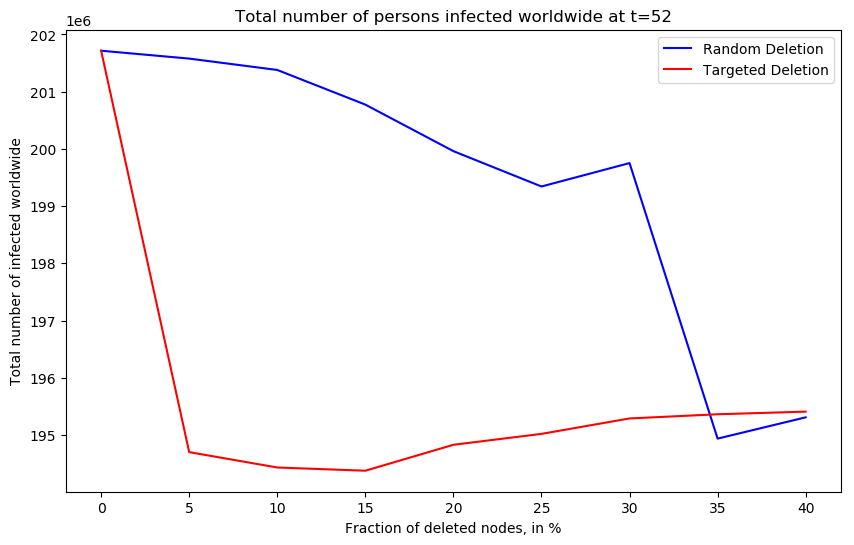

In [79]:
x = list(range(0, 45, 5))

fig, ax = plt.subplots(figsize=(10,6))

plt.plot(x, nb_infected_random, label = 'Random Deletion', color = 'b')
plt.plot(x, nb_infected_targeted, label = 'Targeted Deletion', color = 'r')


plt.title("Total number of persons infected worldwide at t=52")
plt.xlabel("Fraction of deleted nodes, in %")
plt.ylabel("Total number of infected worldwide")
ax.ticklabel_format(axis='y',scilimits=(6,6))
plt.legend()

plt.show()

### Observations :
It is truly interesting to observe that node deletion is not of great use when it comes to fighting the disease, at least in our case.

Indeed, as we saw previously, the first *Epidemic* statuses are only declared at **t=13**. When the pandemic status is declared, at **t=16**, it is already too late ! Even if the major nodes are shut down, the disease is already present and develops in most exposed countries. 

We can see that such policy would not be helpful. Countries have to focus on containing the disease within the country as soon as the first exposed cases are declared. Such actions -modeled here by the decrease in our $R_i$- combined with more border control might help slow the spread of the disease. 

We can however observe that **targeted** deletion is of greater use than a **random** one. With only 5% deletion, it decreases the total number of people infected by the disease by 7M people, whereas a random deletion decreases it only by 200,000 people. After that, for higher deletion ratios, the number of infected people is stagnant for **targeted** deletion, and varies for **random** ones. this is probably due to the high connectivity of our Graph.

# 6. Graph visualisation
## ***==> REFER TO map.ipynb***